In [1]:
import os
os.chdir("..")
import descriptor.three_desc_model as tdm
import numpy as np
import pandas as pd
from cutoffs import Polynomial
from scipy.optimize import minimize,fmin
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
dataset = pd.read_csv('dataset_10m_s.csv', index_col=0)
symbol="Siemens"
numsims=dataset["IDnum"].iloc[-1]+1
turb = [symbol]
nl=tdm.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)


In [2]:
def f(x):
    Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":x[0], "offset": x[3]},
                  {"type":"G4", "elements":"Siemens","eta":x[1], "gamma":x[4]},
                  {"type":"G6", "elements":"Siemens","eta":x[2], "gamma": x[5]}
                 ]}
    finpr=tdm.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
    count=0
    dataset_fp=np.empty(shape=(0, 3))
    dataset_ws=np.empty(shape=(0, 1))
    for i in range(numsims):
        numturb=dataset_full["Num_tot_turb"].iloc[count]
        position = np.empty((numturb,2))
        ws = np.empty((numturb,1))
        fp = np.empty((numturb,3))
        for k in range(numturb):
            position[k,0]=dataset_full.at[count,"X_coord"]
            position[k,1]=dataset_full.at[count,"Y_coord"]
            ws[k,0]=dataset_full.at[count,"Ref_wind"]
            count = count+ 1
        neigh=nl.calculate(turb*numturb,position)
        fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
        fingerprints=np.array(fingerprints)
        dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
        dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
    dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
    X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
    Y=dataset[["Ref_Wind_Speed"]].to_numpy()
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
    Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
    Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
    Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()
    # define kernel
    ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)
    # create simple GP model
    m = GPy.models.GPRegression(Xtrain,Ytrain,ker)
    # optimize and plot
    m.optimize(max_f_eval = 1000)

    [Ypred,Yvar]=m.predict(Xtest)
    return np.max(Ypred-Ytest)

In [3]:
x0 = [5.3, 5., 2., 1., 8., 1.]
bounds= ((0,10),(0,10),(0,10),(0,10),(0,10),(0,10))
res = minimize(f, x0, bounds= bounds, options={'disp':True})

NameError: name 'dataset_full' is not defined

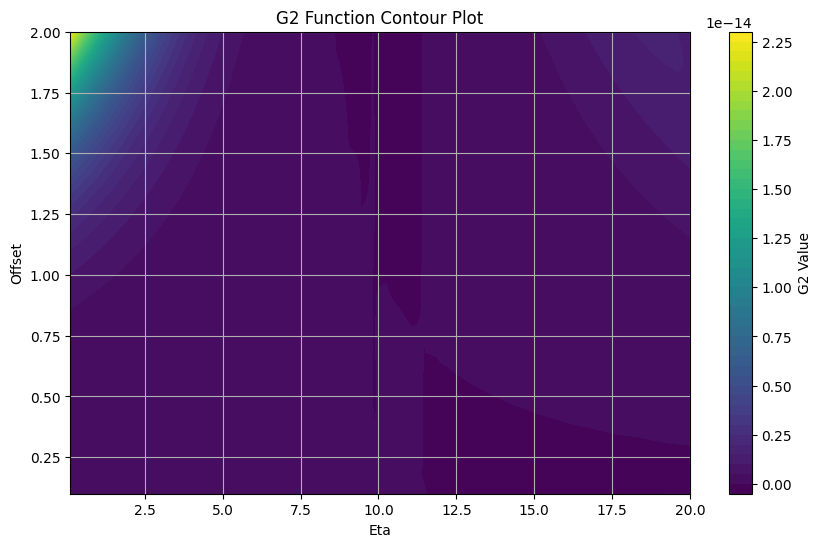

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("..")
import descriptor.three_desc_model as tdm
import numpy as np
import pandas as pd
from cutoffs import Polynomial, Polynomial_2, dict2cutoff
cone_grad=0.12582561117875557 
cone_offset=72.24947126849844
class DescriptorCalculator:
    def __init__(self):
        self.globals = {
            "delta_R": 1.0,
            "cone_grad": 0.1,
            "cone_offset": 1.0,
            "cutoff": cutoff
        }

    def calculate_G2(self, neighborpositions, eta, offset, cutoff, Ri, Rct):
        

        delta_R = self.globals["delta_R"]
        one_grad =  self.globals["cone_grad"]
        cone_offset = self.globals["cone_offset"]
        cutoff=self.globals["cutoff"]
        cutoff=Polynomial(cutoff,Rct).todict()
        cutoff_2=Polynomial_2(delta_R).todict()
        Rc = cutoff['kwargs']['Rc']
        #Rct = cutoff['kwargs']['Rct']
        cutoff_fxn = dict2cutoff(cutoff)
        cutoff_fxn_2 = dict2cutoff(cutoff_2)
        ridge = 1.  # One aspect of a fingerprint :)
        num_neighbors = len(neighborpositions)   # number of neighboring turbine
        for count in range(num_neighbors):
            Rj = neighborpositions[count]
            Rij = np.linalg.norm(Rj - Ri)
            Rcy = (np.abs(Rj[0]-Ri[0]) * cone_grad) + cone_offset
            Ry = np.abs(Rj[1]-Ri[1])
            args_cutoff_fxn = dict(Rij=Rij)
            args_cutoff_fxn_2 = dict(Rij=Ry, Rc=Rcy)
            ridge *= (1-(np.exp(-eta*(Rij - offset) / (Rc)) *
                        cutoff_fxn(**args_cutoff_fxn) * cutoff_fxn_2(**args_cutoff_fxn_2)))
        return ridge



# Create an instance of DescriptorCalculator
descriptor_calculator = DescriptorCalculator()

# Values of eta and offset for the contour plot
eta_values = np.linspace(0.1, 20.0, 50)
offset_values = np.linspace(0.1, 2.0, 50)
# Example data for demonstration
neighborpositions = np.random.rand(10, 3)
cutoff=4001
Ri = [0.0, 0.0, 0.0]
Rct = 3000
# Calculate G2 values for different combinations of eta and offset
g2_values = np.zeros((len(eta_values), len(offset_values)))
for i, eta in enumerate(eta_values):
    for j, offset in enumerate(offset_values):
        g2_values[i, j] = descriptor_calculator.calculate_G2(
            neighborpositions, eta, offset, cutoff, Ri, Rct
        )

# Create the 2D contour plot
plt.figure(figsize=(10, 6))
plt.contourf(eta_values, offset_values, g2_values, levels=50, cmap='viridis')
plt.colorbar(label='G2 Value')
plt.xlabel('Eta')
plt.ylabel('Offset')
plt.title('G2 Function Contour Plot')
plt.grid(True)
plt.show()




